### testing

In [1]:
%load_ext autoreload

In [2]:
%autoreload

In [30]:
import os
from wmhparc.registration import run_ants_SyNAggro, apply_ants_transforms

def register_and_apply(image, template, atlas, output_folder, image_mask=None, template_mask=None):

    out_image = os.path.join(output_folder, image.split(os.path.sep)[-1].split(".nii")[0] + "_lobe_atlas.nii.gz")
    run_ants_SyNAggro(fixed=image, moving=template, out=out_image, outsuffix="template_synaggro", mask=image_mask, moving_mask=template_mask)

    affine_transform = out_image.split(".nii")[0] + "_template_synaggro_0GenericAffine.mat"
    warp_transform = out_image.split(".nii")[0] + "_template_synaggro_1Warp.nii.gz"

    print("applying ants transform")
    apply_ants_transforms(image, atlas, out_image, [affine_transform, warp_transform], is_label=True)

    print("transformed atlas saved to: ", out_image)

In [68]:
image = "/home/s2208943/wmhparc_test/images/NACC788408_3-08-2022_T1w_T1w_0.nii.gz"
template = "/home/s2208943/wmhparc_test/atlas/template_73y_normalized.nii.gz"
brainmask = "/home/s2208943/wmhparc_test/images/NACC788408_3-08-2022_T1w_T1w_0_synthstripmask.nii.gz"
atlas = "/home/s2208943/wmhparc_test/atlas/atlas_bgit.nii.gz"
synthseg = "/home/s2208943/wmhparc_test/images/NACC788408_3-08-2022_T1w_T1w_0_synthseg.nii.gz"
output_folder = "/home/s2208943/wmhparc_test/outputs/"
wmh_seg = "/home/s2208943/wmhparc_test/images/SCAN_NACC788408_3-08-2022_FLAIR_FLAIR_0_seg_high_clamp_bce_sgd05.nii.gz"

In [53]:
register_and_apply(image, template, atlas, output_folder)

ANTS registering /home/s2208943/wmhparc_test/atlas/template_73y_normalized.nii.gz to /home/s2208943/wmhparc_test/images/NACC788408_3-08-2022_T1w_T1w_0.nii.gz
applying ants transform
transformed atlas saved to:  /home/s2208943/wmhparc_test/outputs/NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas.nii.gz


In [54]:
%autoreload

In [116]:
import os
from wmhparc.concentric_layers import postprocess_synthseg, create_pv_dist_ring_file

def compute_concentric_layers(synthseg, brainmask, output_folder):
    print("computing ventricle and cortex distance transforms")
    ventmap_outimage, cortexmap_outimage = postprocess_synthseg(image, synthseg, output_folder)

    print("creating concentric layers images")
    pv_rings_file = create_pv_dist_ring_file(image, synthseg, ventmap_outimage, cortexmap_outimage, brainmask, output_folder)

    return pv_rings_file

In [56]:
compute_concentric_layers(synthseg, brainmask, output_folder)

computing ventricle and cortex distance transforms


INFO: using NIfTI-1 sform (sform_code=1)
INFO: using NIfTI-1 sform (sform_code=1)
INFO: using NIfTI-1 sform (sform_code=1)
INFO: using NIfTI-1 sform (sform_code=1)
INFO: using NIfTI-1 sform (sform_code=1)


creating concentric layers images
saved concentric layers segmentation to:  /home/s2208943/wmhparc_test/outputs/NACC788408_3-08-2022_T1w_T1w_0_pvrings.nii.gz


In [57]:
%autoreload

In [64]:
output_atlas = "/home/s2208943/wmhparc_test/outputs/NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas.nii.gz"
pvrings = "/home/s2208943/wmhparc_test/outputs/NACC788408_3-08-2022_T1w_T1w_0_pvrings.nii.gz"
parc_output = "/home/s2208943/wmhparc_test/outputs/NACC788408_3-08-2022_T1w_T1w_0_bullseye_parc.nii.gz"

In [65]:


from wmhparc.parcellate_image import save_brain_parcellation_image

save_brain_parcellation_image(output_atlas, pvrings)

In [84]:
from wmhparc.utils import load_image
import numpy as np
import SimpleITK as sitk
from wmhparc.parcellate_image import parcellate_from_brainroi
import pandas as pd

def calc_parc_stats(image, parc_file, wmh_seg):
    brainroi = load_image(parc_file)
    wmh = load_image(wmh_seg)
    voxel_size = np.prod(sitk.ReadImage(image).GetSpacing())
    
    results = parcellate_from_brainroi(brainroi, wmh, voxel_size)
    results = {key:[value] for key, value in results.items()}
    return pd.DataFrame(results)

    return results

In [85]:
result = calc_parc_stats(image, parc_output, wmh_seg)

In [86]:
result

,wmh_frontal-left_layer1,wmh_frontal-left_layer2,wmh_frontal-left_layer3,wmh_frontal-left_layer4,wmh_parietal-left_layer1,wmh_parietal-left_layer2,wmh_parietal-left_layer3,wmh_parietal-left_layer4,wmh_temporal-left_layer1,wmh_temporal-left_layer2,...,wmh_parietal-right_layer3,wmh_parietal-right_layer4,wmh_temporal-right_layer1,wmh_temporal-right_layer2,wmh_temporal-right_layer3,wmh_temporal-right_layer4,wmh_occipital-right_layer1,wmh_occipital-right_layer2,wmh_occipital-right_layer3,wmh_occipital-right_layer4
0,15.600001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.800001,...,0.0,0.0,0.0,0.0,0.0,0.0,9.6,2.4,0.0,0.0


In [2]:
ls ~/wmhparc_test/

atlas/  images/  outputs/


In [13]:
ls ~/wmhparc_test/images

atlas_bgit.nii.gz
basevisit_brainroi.nii.gz
NACC788408_3-08-2022_FLAIR_FLAIR_0.nii.gz
NACC788408_3-08-2022_T1w_T1w_0.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_synthseg.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_synthstripmask.nii.gz
SCAN_NACC788408_3-08-2022_FLAIR_FLAIR_0_seg_high_clamp_bce_sgd05.nii.gz


In [8]:
ls /home/s2208943/wmhparc_test/atlas

atlas_bgit.nii.gz  template_73y_normalized.nii.gz


In [121]:
ls /home/s2208943/wmhparc_test/outputs/

NACC788408_3-08-2022_T1w_T1w_0_bullseye_parc.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_cortexdist.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas_template_synaggro_0GenericAffine.mat
NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas_template_synaggro_1InverseWarp.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas_template_synaggro_1Warp.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_pvrings.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_ventdist.nii.gz


In [ ]:
mkdir /home/s2208943/wmhparc_test/outputs2/

In [123]:
ls /home/s2208943/wmhparc_test/outputs2/

NACC788408_3-08-2022_T1w_T1w_0_bullseye_parc.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_bullseye_parcwmh_parc_vols.csv
NACC788408_3-08-2022_T1w_T1w_0_cortexdist.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas_template_synaggro_0GenericAffine.mat
NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas_template_synaggro_1InverseWarp.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_lobe_atlas_template_synaggro_1Warp.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_pvrings.nii.gz
NACC788408_3-08-2022_T1w_T1w_0_ventdist.nii.gz


In [124]:
cat /home/s2208943/wmhparc_test/outputs2/NACC788408_3-08-2022_T1w_T1w_0_bullseye_parcwmh_parc_vols.csv

,wmh_frontal-left_layer1,wmh_frontal-left_layer2,wmh_frontal-left_layer3,wmh_frontal-left_layer4,wmh_parietal-left_layer1,wmh_parietal-left_layer2,wmh_parietal-left_layer3,wmh_parietal-left_layer4,wmh_temporal-left_layer1,wmh_temporal-left_layer2,wmh_temporal-left_layer3,wmh_temporal-left_layer4,wmh_occipital-left_layer1,wmh_occipital-left_layer2,wmh_occipital-left_layer3,wmh_occipital-left_layer4,wmh_bgit_layer1,wmh_bgit_layer2,wmh_bgit_layer3,wmh_bgit_layer4,wmh_frontal-right_layer1,wmh_frontal-right_layer2,wmh_frontal-right_layer3,wmh_frontal-right_layer4,wmh_parietal-right_layer1,wmh_parietal-right_layer2,wmh_parietal-right_layer3,wmh_parietal-right_layer4,wmh_temporal-right_layer1,wmh_temporal-right_layer2,wmh_temporal-right_layer3,wmh_temporal-right_layer4,wmh_occipital-right_layer1,wmh_occipital-right_layer2,wmh_occipital-right_layer3,wmh_occipital-right_layer4
0,15.600000619888306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.800000429153442,1.2000000476837158,0.0,0.0,7.200000286102295,15

In [11]:
# cp -r /home/s2208943/wmhparc_test/images /home/s2208943/wmhparc_test/images_copy

In [91]:
from wmhparc.utils import load_image
import matplotlib.pyplot as plt

In [96]:
t1 = load_image(image)
lobe_atlas = load_image(os.path.join("/home/s2208943/wmhparc_test/outputs/", "NACC788408_3-08-2022_T1w_T1w_0_bullseye_parc.nii.gz"))

In [100]:
np.unique(lobe_atlas)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.])

In [97]:
lobe_atlas.shape, t1.shape

((256, 256, 160), (256, 256, 160))

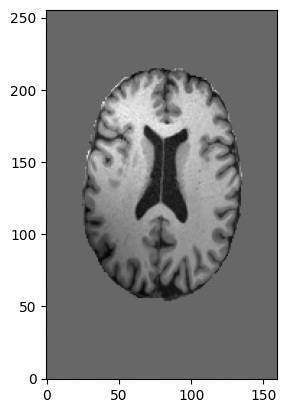

In [98]:
plt.imshow(t1[128], origin='lower', cmap='gray')

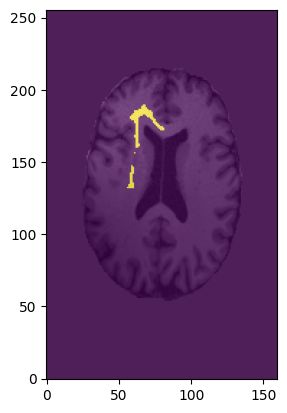

In [114]:
plt.imshow(t1[128], origin='lower', cmap='gray')
plt.imshow(lobe_atlas[128]==3, origin='lower', alpha=0.7, cmap='viridis')

In [107]:
np.unique(lobe_atlas)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.])

In [126]:
ssm = load_image("/home/s2208943/projects/twaibrain/twaibrain/brainpreprep/atlas_templates/atlas_image/template_73y_synthstripmask.nii.gz")

In [127]:
ssm.shape

(256, 156, 256)

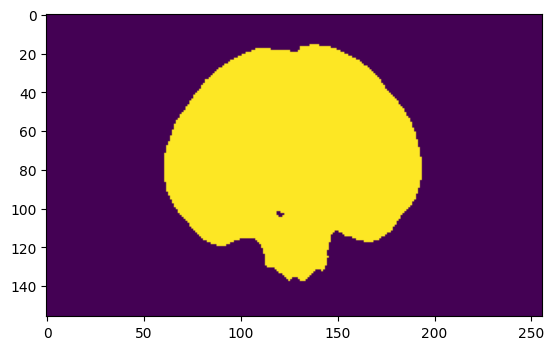

In [128]:
plt.imshow(ssm[128])

In [129]:
t = load_image(template)

In [130]:
t.shape

(256, 156, 256)

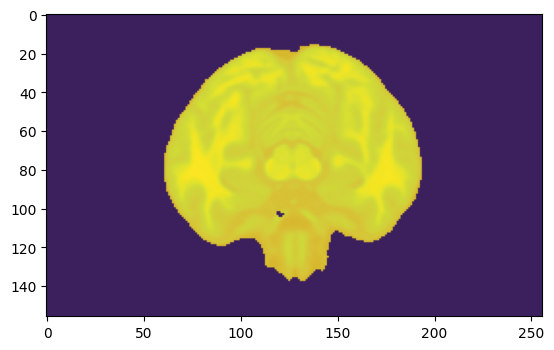

In [132]:
plt.imshow(t[128])
plt.imshow(ssm[128], alpha=0.8)